In [1]:
import os
import pathlib

# make sure current directory is MineGen
if pathlib.Path.cwd().name != "MineGen":
    os.chdir("..")

assert pathlib.Path.cwd().name == "MineGen"

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from data.datasets.schematics import SchematicDataModule, SchematicDataset
from einops.layers.torch import Rearrange
from nbtschematic import SchematicFile

c:\Users\connor\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        activation=nn.GELU,
        norm=nn.BatchNorm3d,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding=kernel_size // 2,
                bias=False,
            ),
            norm(out_channels),
            activation(),
            nn.ConvTranspose3d(out_channels, out_channels, kernel_size, bias=False),
            norm(out_channels),
        )
        self.shortcut = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels, out_channels, kernel_size=1, stride=stride, bias=False
            ),
            norm(out_channels),
        )

    def forward(self, x):
        return self.block(x) + self.shortcut(x)

In [84]:
class VAE(pl.LightningModule):
    def __init__(self, latent_dim, num_blocks, embedding_size, num_categories):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.embedding = nn.Embedding(num_blocks, embedding_size)
        self.encoder = nn.Sequential(
            nn.Conv3d(embedding_size, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(8),
            nn.GELU(),
            nn.Conv3d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(16),
            nn.GELU(),
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm3d(32),
            nn.GELU(),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.GELU(),
        )
        self.linear_mu = nn.Linear(128, latent_dim)
        self.linear_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.GELU(),
            Rearrange("b (d c h w) -> b c d h w", c=128, d=1, h=1, w=1),
            ResidualBlock(128, 32, 1, stride=1),
            ResidualBlock(32, 16, 3, stride=3),
            nn.ConvTranspose3d(16, 8, 3, stride=3, padding=1),
            nn.BatchNorm3d(8),
            nn.GELU(),
            nn.ConvTranspose3d(
                8, embedding_size, 3, stride=2, padding=0, output_padding=1
            ),
        )

        self.category_predictor = nn.Linear(latent_dim, num_categories)

    def encode(self, x):
        x = self.embedding(x)
        x = x.permute(
            0, 4, 1, 2, 3
        )  # Move the embedding dimension to the channel dimension
        x = self.encoder(x)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder(z)
        # x = x.permute(0, 2, 3, 4, 1)  # Move the embedding dimension back to the end
        return x

    def forward(self, x):
        x_mu, logvar = self.encode(x)
        z = self.reparameterize(x_mu, logvar)
        recon_x = self.decode(z)
        category_logits = self.category_predictor(z)
        return recon_x, category_logits, x_mu, logvar

    def training_step(self, batch, batch_idx):
        x, y = batch
        recon_x, category_logits, x_mu, logvar = self(x)
        # recon_loss = F.cross_entropy(recon_x.view(-1, recon_x.shape[-1]), x.view(-1), reduction='sum')
        recon_loss = F.cross_entropy(recon_x, x)
        category_loss = F.cross_entropy(category_logits, y)
        kld_loss = -0.5 * torch.sum(1 + logvar - x_mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss + category_loss
        self.log("train/train_loss", loss)
        self.log("train/recon_loss", recon_loss)
        self.log("train/kld_loss", kld_loss)
        self.log("train/category_loss", category_loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        recon_x, category_logits, x_mu, logvar = self(x)
        # recon_loss = F.cross_entropy(recon_x.view(-1, recon_x.shape[-1]), x.view(-1), reduction='sum')
        recon_loss = F.cross_entropy(recon_x, x)
        category_loss = F.cross_entropy(category_logits, y)
        kld_loss = -0.5 * torch.sum(1 + logvar - x_mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss + category_loss
        self.log("val/val_loss", loss)
        self.log("val/recon_loss", recon_loss)
        self.log("val/kld_loss", kld_loss)
        self.log("val/category_loss", category_loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Training

In [85]:
categories = dm.train_dataset.dataset.enc.categories_[0]

In [15]:
dm = SchematicDataModule(batch_size=128)
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", log_every_n_steps=1)
model = VAE(64, 512, 512, len(categories))
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer = pl.Trainer(max_epochs=2000, accelerator="gpu", log_every_n_steps=1)
dm = SchematicDataModule(batch_size=128)
model = VAE(64, 512, 512, 17)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\connor\miniconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params
--------------------------------------------------
0 | embedding          | Embedding  | 262 K 
1 | encoder            | Sequential | 127 K 
2 | linear_mu          | Linear     | 8.3 K 
3 | linear_logvar      | Linear     | 8.3 K 
4 | decoder            | Sequential | 153 K 
5 | category_predictor | Linear     | 1.1 K 
--------------------------------------------------
561 K     Trainable params
0         Non-trainable params
561 K     Total params
2.246     Total estimated

Epoch 1999: 100%|██████████| 2/2 [00:08<00:00,  4.43s/it, v_num=235]        

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 2/2 [00:08<00:00,  4.45s/it, v_num=235]


## Evaluation

In [73]:
# inference example
x, y = next(iter(dm.val_dataloader()))
recon_x, category_logits, x_mu, logvar = model(x)

In [74]:
print(f"Unique blocks in input: {torch.unique(x[i:=5])}")
print(f"Unique blocks in output: {torch.unique(torch.argmax(recon_x[i], dim=1))}")
print(f"Category: {torch.argmax(y, dim=1)}")
print(f"Predicted category: {torch.argmax(category_logits, dim=1)}")

Unique blocks in input: tensor([  0,   3,  35, 104])
Unique blocks in output: tensor([ 0,  1,  2,  4,  5,  6,  7, 12, 15])
Category: tensor([11, 17, 13,  9,  3, 14, 18, 15, 15, 10, 10, 15, 11,  3, 10, 11, 11, 15,
        15, 13, 11, 15, 11, 11, 18,  4, 13, 15, 13, 15,  0, 11, 11, 13, 11, 11,
         5, 11, 13, 11, 13, 11, 16, 13,  9,  1, 13, 11, 15, 15, 11,  5, 13, 10,
        11, 11,  9, 15, 15, 13, 11, 13, 11, 10, 15, 14, 11,  9, 15, 13, 13, 11,
        15, 15, 11, 13, 13, 10, 13, 15, 14,  3, 13, 10, 10, 11, 15, 15, 15,  5,
        15, 11, 15, 11, 15, 11,  5, 13, 15,  1, 10, 15, 17, 16, 17, 13,  4, 15,
         3, 13, 11, 15, 10, 13, 11, 13,  8, 11, 15, 13, 13, 15, 15, 11, 11, 11,
        11, 13])
Predicted category: tensor([10, 13, 15,  5, 14, 13, 13, 19, 15, 14, 11, 11,  4, 10, 15, 15, 17, 14,
         4, 13, 17,  8, 14, 11,  4,  0, 13,  4, 13, 10,  8, 15, 15,  0, 11, 11,
        13,  9, 17, 10,  7, 10,  9,  3, 14,  8, 14, 10, 17, 14, 15,  9,  7,  9,
        18,  3, 15, 13,  5, 15

In [75]:
# map predicted category to category name
enc = dm.train_dataset.dataset.enc
y_pred = enc.inverse_transform(category_logits.detach().numpy()).reshape(-1)
y_gt = enc.inverse_transform(y.detach().numpy()).reshape(-1)

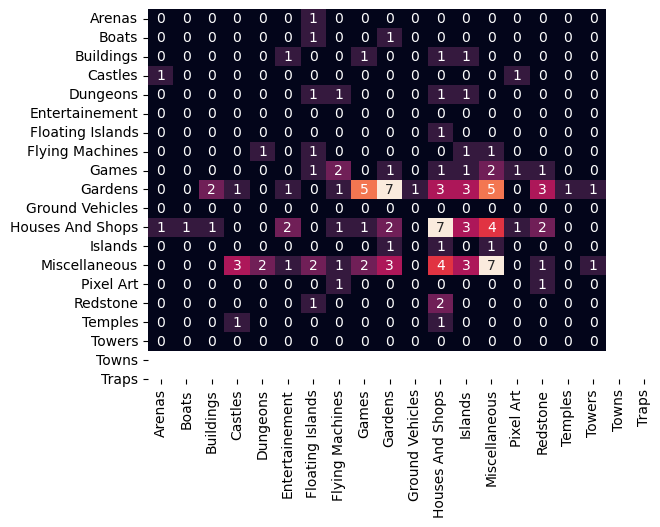

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Confusion matrix

cm = confusion_matrix(y_gt, y_pred)
g = sns.heatmap(
    cm,
    cbar=False,
    annot=True,
    fmt="d",
    xticklabels=enc.categories_[0],
    yticklabels=enc.categories_[0],
)

In [54]:
torch.unique(torch.tensor(y_pred.reshape()))

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
torch.argmax(category_logits, dim=1)

tensor([12, 12, 12,  9,  9,  9,  9,  9, 12,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        12, 12,  9,  9, 12,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9, 12, 12,  9])

In [ ]:
# save model
torch.save(model.state_dict(), "vae.pt")

In [ ]:
torch.argmax(recon_x, dim=1).unique()

tensor([0])

In [ ]:
torch.argmax(recon_x, dim=1).shape

torch.Size([43, 16, 16, 16])

In [ ]:
recon_x.shape

torch.Size([43, 256, 16, 16, 16])

In [ ]:
sf = SchematicFile(shape=(16, 16, 16), blocks=torch.argmax(recon_x, dim=1)[5].numpy())

In [ ]:
torch.unique(torch.argmax(recon_x, dim=1))

tensor([0])

In [ ]:
x[0]

tensor([[[  2,   2,   2,  ...,   0,   0,   0],
         [  2,   2,   3,  ...,   0,   0,   0],
         [  2,   2,   5,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   5,  ...,   0,   0,   0],
         [  0, 109,  61,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   5,  ...,   0,   0,   0],
         [  0, 109,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        ...,

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]

In [ ]:
x_mu[0]

tensor([-9.7938e-05, -1.9896e-04,  2.9781e-04,  3.1382e-04, -2.2341e-05,
         1.7537e-04,  3.5753e-04,  3.7152e-05,  5.2612e-05,  7.7568e-05,
        -4.6708e-05,  1.0428e-04,  4.6038e-04,  9.5330e-05, -1.1713e-04,
         6.6530e-05,  8.6896e-05,  3.2444e-05, -4.9794e-05,  1.7773e-04,
        -1.8923e-05, -1.5575e-04,  2.0374e-04,  1.8984e-04, -3.7895e-04,
        -3.4055e-05, -2.7430e-04,  1.9004e-04, -2.4338e-04,  8.8468e-05,
         2.6061e-05,  4.5571e-05,  2.2324e-04, -6.4851e-05,  2.5643e-04,
         3.1790e-04, -6.0193e-05, -1.6185e-04,  3.5550e-04,  2.6908e-04,
        -2.3569e-04,  1.0586e-04,  1.5857e-04, -2.0472e-04, -1.7186e-04,
         1.1450e-04, -3.2048e-04, -1.0984e-04, -4.2632e-05, -5.2167e-05,
         1.1121e-04,  8.6391e-05, -2.1588e-04,  1.5632e-04,  2.2833e-04,
        -1.5539e-05, -1.4213e-04,  6.0871e-06,  1.0831e-04, -1.2220e-04,
        -4.7244e-05,  3.4053e-04, -3.4522e-04,  1.4331e-04],
       grad_fn=<SelectBackward0>)

In [ ]:
x.unique(return_counts=True)

(tensor([  0,   1,   2,   3,   4,   5,   7,   9,  11,  12,  13,  17,  18,  20,
          23,  24,  25,  26,  27,  29,  31,  32,  33,  34,  35,  38,  39,  40,
          41,  42,  43,  44,  47,  48,  49,  50,  53,  54,  55,  58,  59,  60,
          61,  62,  63,  64,  65,  67,  68,  69,  70,  71,  72,  73,  75,  76,
          77,  78,  79,  80,  81,  83,  85,  87,  89,  90,  91,  92,  93,  94,
          95,  96,  97,  98,  99, 100, 101, 102, 104, 105, 106, 107, 109, 110,
         111, 112, 113, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127]),
 tensor([160483,   1073,    680,    912,    993,   1232,    132,    399,     26,
              6,     92,    434,     93,    243,      5,     89,      1,     10,
              6,    107,     47,      3,     29,     52,    661,     32,      4,
              4,     91,    248,    311,    501,     84,    677,     20,     68,
            111,     62,    291,      7,      4,      6,     26,      2,     10,
             12,     56,     92,     71,

In [ ]:
sf.save("monkey.schematic")

In [ ]:
torch.unique(torch.argmax(recon_x[5], dim=1))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
torch.argmax(category_logits, dim=1)

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [ ]:
torch.argmax(y, dim=1)

tensor([12, 15,  7, 12, 15, 10, 12,  9,  6, 10,  9, 12,  7, 12, 12,  9,  4,  9,
         9,  9, 12, 12, 12, 10, 10,  3, 15, 10, 16, 11,  7,  7, 12,  9, 12, 12,
         9, 10, 12, 12,  9,  9, 12])